# LSTM — Prédiction autorégressiive de la dernière semaine

## Objectif
Ce notebook construit un **LSTM (Long Short-Term Memory)** pour prédire `Total_reservations`
via une **fenêtre glissante autorégressiive**.

## Architecture
```
Input (batch, WINDOW, n_features)
   ↓
LSTM(hidden=HIDDEN_SIZE, layers=NUM_LAYERS, dropout=DROPOUT)
   ↓  h_T  (batch, HIDDEN_SIZE)
Dropout
   ↓
Linear(HIDDEN_SIZE → 1)
   ↓
Total_reservations normalisé [0, 1]
```

## Pourquoi le LSTM résout le vanishing gradient ?
Le LSTM introduit une **cellule de contexte** $c_t$ mise à jour par additions :
$$c_t = f_t \odot c_{t-1} + i_t \odot \tilde{c}_t$$
Les gradients peuvent traverser le temps sans disparaître, contrairement au SimpleRNN.

## Stratégie autorégressiive
Pour prédire la **dernière semaine** (5 jours) :
1. Fenêtre initiale = les `WINDOW` jours précédents (valeurs réelles)
2. Prédiction du lundi → injectée dans la fenêtre
3. Prédiction du mardi avec la fenêtre glissée → etc.
4. Les **features exogènes** (météo, jours fériés) sont connues à l'avance et utilisées telles quelles.

## Paramètres comparables inter-modèles
| Paramètre | Valeur | Rôle |
|-----------|--------|------|
| `WINDOW` | 5 | Jours de contexte (1 semaine ouvrée) |
| `N_TEST` | 5 | Jours à prédire (dernière semaine) |
| `TARGET_COL` | `Total_reservations` | Variable cible |
| `EPOCHS` | 200 | Epochs max d'entraînement |
| `HIDDEN_SIZE` | 64 | Dimension de l'état caché |
| `NUM_LAYERS` | 2 | Couches LSTM empilées |

## 1 — Configuration globale

**Modifiez uniquement ce bloc** pour changer les hyperparamètres.

In [1]:
# ─────────────────────────────────────────────────────────────────
# PARAMÈTRES GLOBAUX — modifier ici pour ajuster l'expérience
# ─────────────────────────────────────────────────────────────────
DATA_PATH   = '../data/df_venues_final.csv'
TARGET_COL  = 'GLOBAL'   # variable à prédire
MODEL_NAME  = 'LSTM'

WINDOW      = 5      # jours de contexte (fenêtre glissante)
N_TEST      = 5      # jours de test = dernière semaine

# Entraînement
EPOCHS      = 200
LR          = 1e-3
BATCH_SIZE  = 16
WEIGHT_DECAY = 1e-5
PATIENCE    = 20     # early stopping : patience en epochs

# Architecture LSTM
HIDDEN_SIZE = 64
NUM_LAYERS  = 2
DROPOUT     = 0.2

# Features utilisées (ordre fixe — TARGET_COL en index 0 pour l'autoregression)
FEATURES = [
    'GLOBAL',               # idx 0 — feedback autorégressif
    'Total_reservations', 'Temp', 'pluie', 'autre',
    'Greve_nationale', 'prof_nationale',
    'jour_ferie.', 'pont.conge.', 'holiday',
    'jour_lundi', 'jour_mardi', 'jour_mercredi', 'jour_jeudi', 'jour_vendredi',
]
TARGET_IDX = 0   # index de TARGET_COL dans FEATURES

DAY_LABELS = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi']
IMG_PATH   = f'../img/{MODEL_NAME.lower()}_results.png'

## 2 — Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

torch.manual_seed(42)
np.random.seed(42)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'PyTorch : {torch.__version__} | Device : {DEVICE}')

PyTorch : 2.10.0 | Device : cpu


## 3 — Chargement et tri chronologique

Les données sont triées par **(Annee, Semaine, jour de la semaine)** pour respecter l'ordre temporel.
Les colonnes booléennes (`jour_*`) sont converties en entiers.

In [3]:
df = pd.read_csv(DATA_PATH, sep=';')

day_order = {
    'jour_lundi': 0, 'jour_mardi': 1, 'jour_mercredi': 2,
    'jour_jeudi': 3, 'jour_vendredi': 4,
}
for col in day_order:
    df[col] = df[col].map({'True': 1, 'False': 0}).fillna(df[col]).astype(int)

df['day_num'] = df[list(day_order.keys())].idxmax(axis=1).map(day_order)
df = df.sort_values(['Annee', 'Semaine', 'day_num']).reset_index(drop=True)

print(f'Shape : {df.shape}')
_last = df.iloc[-N_TEST:]
TEST_LABEL = f"S{int(_last.iloc[0]['Semaine'])}/{int(_last.iloc[0]['Annee'])}"
print(f'Période : {df["Annee"].min()}/S{df["Semaine"].min()} → {df["Annee"].max()}/S{df["Semaine"].max()}')
print(f'\n--- Dernière semaine de test ({TEST_LABEL}) ---')
print(df[['Annee', 'Semaine', 'day_num', TARGET_COL]].tail(N_TEST).to_string())

Shape : (250, 18)
Période : 2022/S1 → 2023/S51

--- Dernière semaine de test (S39/2023) ---
     Annee  Semaine  day_num  GLOBAL
245   2023       39        0     624
246   2023       39        1     713
247   2023       39        2     623
248   2023       39        3     659
249   2023       39        4     408


## 4 — Prétraitement et séquences

### Normalisation
Un seul `MinMaxScaler` est ajusté sur **toutes les données** (train + test) pour les features.
La cible `Total_reservations` (idx 0) est normalisée dans le même espace → les prédictions
autoregressives sont directement injectables dans la fenêtre.

### Séquences glissantes
Chaque échantillon `(X, y)` est construit ainsi :
- `X` : fenêtre de `WINDOW` jours consécutifs → shape `(WINDOW, n_features)`
- `y` : valeur de `Total_reservations` du jour suivant (normalisée)

**Split** : les `N_TEST` derniers jours forment le test — aucune fuite d'information.

In [4]:
scaler   = MinMaxScaler()
X_scaled = scaler.fit_transform(df[FEATURES].astype(float))  # (N, n_features)

X_train_raw = X_scaled[:-N_TEST]
X_test_raw  = X_scaled[-N_TEST:]

def make_sequences(X, window):
    """Transforme un tableau (N, F) en séquences glissantes pour apprentissage supervisé."""
    Xs, ys = [], []
    for i in range(window, len(X)):
        Xs.append(X[i - window : i])       # (window, n_features)
        ys.append(X[i, TARGET_IDX])        # cible normalisée
    return np.array(Xs, dtype=np.float32), np.array(ys, dtype=np.float32).reshape(-1, 1)

X_seq, y_seq = make_sequences(X_train_raw, WINDOW)

print(f'Séquences train : {X_seq.shape}  →  {y_seq.shape}')
seed_start = len(df) - N_TEST - WINDOW
print(f'\nFenêtre seed (indices {seed_start}–{seed_start + WINDOW - 1}) :')
print(df[['Annee', 'Semaine', 'day_num', TARGET_COL]].iloc[seed_start:seed_start + WINDOW].to_string())

X_tr = torch.tensor(X_seq).to(DEVICE)
y_tr = torch.tensor(y_seq).to(DEVICE)
train_loader = DataLoader(TensorDataset(X_tr, y_tr), batch_size=BATCH_SIZE, shuffle=True)

Séquences train : (240, 5, 15)  →  (240, 1)

Fenêtre seed (indices 240–244) :
     Annee  Semaine  day_num  GLOBAL
240   2023       38        0     676
241   2023       38        1     764
242   2023       38        2     714
243   2023       38        3     677
244   2023       38        4     558


## 5 — Architecture LSTM

```
Input  : (batch, WINDOW=5, n_features=15)
   ↓
LSTM(hidden=64, layers=2, dropout=0.2)
   ↓  h_T  (batch, 64)
Dropout(0.2)
   ↓
Linear(64 → 1)
   ↓
Total_reservations normalisé [0, 1]
```

**Différence avec GRU/RNN :** le LSTM maintient deux états : `h_t` (état caché) et `c_t` (cellule
de contexte). La cellule permet aux gradients de circuler sans disparaître (**Long Short-Term Memory**).

**Sorties de `nn.LSTM`** : `(output, (h_n, c_n))` — on utilise uniquement le dernier `h_T`.

In [5]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=HIDDEN_SIZE,
                 num_layers=NUM_LAYERS, dropout=DROPOUT):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.dropout = nn.Dropout(dropout)
        self.fc      = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _  = self.lstm(x)               # (batch, T, hidden)
        last_h  = out[:, -1, :]              # dernier pas de temps
        return self.fc(self.dropout(last_h))  # (batch, 1)


model = LSTMModel(input_size=len(FEATURES)).to(DEVICE)
print(model)
print(f'\nNombre de paramètres : {sum(p.numel() for p in model.parameters()):,}')

LSTMModel(
  (lstm): LSTM(15, 64, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

Nombre de paramètres : 54,081


## 6 — Entraînement

- **Optimiseur** : Adam avec weight decay (`WEIGHT_DECAY`)
- **Scheduler** : `ReduceLROnPlateau` — divise le LR par 2 si la loss stagne `PATIENCE` epochs
- **Loss** : MSE sur les valeurs normalisées
- **Gradient clipping** : norme max = 1.0 pour stabiliser l'entraînement

In [6]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=PATIENCE, factor=0.5
)

loss_history = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    epoch_loss = 0.0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(xb), yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        epoch_loss += loss.item() * xb.size(0)
    epoch_loss /= len(X_seq)
    loss_history.append(epoch_loss)
    scheduler.step(epoch_loss)

    if epoch % 50 == 0:
        lr_cur = optimizer.param_groups[0]['lr']
        print(f'Epoch {epoch:3d}/{EPOCHS} | Loss : {epoch_loss:.5f} | LR : {lr_cur:.6f}')

print('\nEntraînement terminé.')

Epoch  50/200 | Loss : 0.01460 | LR : 0.001000
Epoch 100/200 | Loss : 0.01168 | LR : 0.001000
Epoch 150/200 | Loss : 0.00953 | LR : 0.001000
Epoch 200/200 | Loss : 0.00870 | LR : 0.001000

Entraînement terminé.


## 7 — Prédiction autorégressiive (fenêtre glissante)

**Pour chaque jour `t` de la semaine cible :**

1. Construire le tenseur `x` depuis la fenêtre courante `(WINDOW × n_features)`
2. Passer `x` dans le LSTM → `ŷ_t` normalisé
3. Créer le vecteur du jour `t` : features exogènes réelles + `Total_reservations = ŷ_t`
4. Glisser la fenêtre : `window = [window[1:], nouveau_jour]`
5. Répéter pour `t+1`

⚠️ Les features exogènes (météo, jours fériés…) sont connues à l'avance → on utilise les vraies valeurs.

In [7]:
model.eval()

seed_window = X_scaled[-N_TEST - WINDOW : -N_TEST].copy()
preds_norm  = []
window      = seed_window.copy()

print('=== Prédiction autorégressiive (fenêtre glissante) ===')
print(f"{'Étape':<6} {'Jour':<10} {'ŷ norm':>8}   Fenêtre {TARGET_COL} [normalisé]")
print('-' * 70)

for step in range(N_TEST):
    x = torch.tensor(window, dtype=torch.float32).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        pred_n = model(x).item()
    preds_norm.append(pred_n)

    print(f'  {step}     {DAY_LABELS[step]:<10} {pred_n:>8.4f}   '
          f'{np.round(window[:, TARGET_IDX], 3)}')

    new_day             = X_test_raw[step].copy()
    new_day[TARGET_IDX] = pred_n
    window = np.vstack([window[1:], new_day.reshape(1, -1)])

# Dénormalisation
dummy                = np.zeros((N_TEST, len(FEATURES)))
dummy[:, TARGET_IDX] = preds_norm
preds_real = scaler.inverse_transform(dummy)[:, TARGET_IDX]
real_real  = df[TARGET_COL].values[-N_TEST:]

print('\n=== Résultats ===')
print(f"{'Jour':<10} | {'Réel':>6} | {MODEL_NAME:>6} | {'Erreur':>7} | {'Erreur %':>8}")
print('-' * 48)
for i, d in enumerate(DAY_LABELS):
    err    = preds_real[i] - real_real[i]
    err_pc = 100 * abs(err) / real_real[i]
    print(f'{d:<10} | {real_real[i]:>6.0f} | {preds_real[i]:>6.0f} | {err:>+7.0f} | {err_pc:>7.1f}%')

=== Prédiction autorégressiive (fenêtre glissante) ===
Étape  Jour         ŷ norm   Fenêtre GLOBAL [normalisé]
----------------------------------------------------------------------
  0     Lundi        0.7090   [0.718 0.814 0.76  0.719 0.589]
  1     Mardi        0.8041   [0.814 0.76  0.719 0.589 0.709]
  2     Mercredi     0.7650   [0.76  0.719 0.589 0.709 0.804]
  3     Jeudi        0.7206   [0.719 0.589 0.709 0.804 0.765]
  4     Vendredi     0.4913   [0.589 0.709 0.804 0.765 0.721]

=== Résultats ===
Jour       |   Réel |   LSTM |  Erreur | Erreur %
------------------------------------------------
Lundi      |    624 |    668 |     +44 |     7.0%
Mardi      |    713 |    755 |     +42 |     5.9%
Mercredi   |    623 |    719 |     +96 |    15.4%
Jeudi      |    659 |    678 |     +19 |     2.9%
Vendredi   |    408 |    469 |     +61 |    14.8%


## 8 — Métriques

| Métrique | Formule | Interprétation |
|----------|---------|----------------|
| **MAE** | $\frac{1}{n}\sum|y_i - \hat{y}_i|$ | Erreur moyenne en nombre de réservations |
| **MAPE** | $\frac{100}{n}\sum\frac{|y_i - \hat{y}_i|}{y_i}$ | Erreur relative en % |
| **RMSE** | $\sqrt{\frac{1}{n}\sum(y_i - \hat{y}_i)^2}$ | Pénalise les grandes erreurs |
| **R²** | $1 - \frac{\sum(y_i - \hat{y}_i)^2}{\sum(y_i - \bar{y})^2}$ | 1 = parfait, 0 = moyenne naïve |

In [8]:
mae  = mean_absolute_error(real_real, preds_real)
mape = mean_absolute_percentage_error(real_real, preds_real) * 100
rmse = np.sqrt(np.mean((real_real - preds_real) ** 2))
r2   = r2_score(real_real, preds_real)

print(f'╔{"═" * 50}╗')
print(f'║  Métriques {MODEL_NAME} — {TEST_LABEL:<{36}}║')
print(f'╠{"═" * 50}╣')
print(f'║  MAE   (Erreur absolue moyenne)  : {mae:>7.1f} réserv. ║')
print(f'║  MAPE  (Erreur % moyenne)        : {mape:>6.2f}%          ║')
print(f'║  RMSE  (Racine erreur quadrat.)  : {rmse:>7.1f} réserv. ║')
print(f'║  R²    (Coefficient det.)        : {r2:>7.4f}           ║')
print(f'╚{"═" * 50}╝')

╔══════════════════════════════════════════════════╗
║  Métriques LSTM — S39/2023                            ║
╠══════════════════════════════════════════════════╣
║  MAE   (Erreur absolue moyenne)  :    52.3 réserv. ║
║  MAPE  (Erreur % moyenne)        :   9.21%          ║
║  RMSE  (Racine erreur quadrat.)  :    58.1 réserv. ║
║  R²    (Coefficient det.)        :  0.6874           ║
╚══════════════════════════════════════════════════╝


## 9 — Visualisations

Trois graphiques standardisés (identiques pour tous les modèles) :
1. **Courbe d'apprentissage** — convergence de la loss MSE par epoch
2. **Série complète + prédiction** — vue globale avec zoom sur la semaine de test
3. **Barres côte à côte** — comparaison jour par jour réel vs prédit

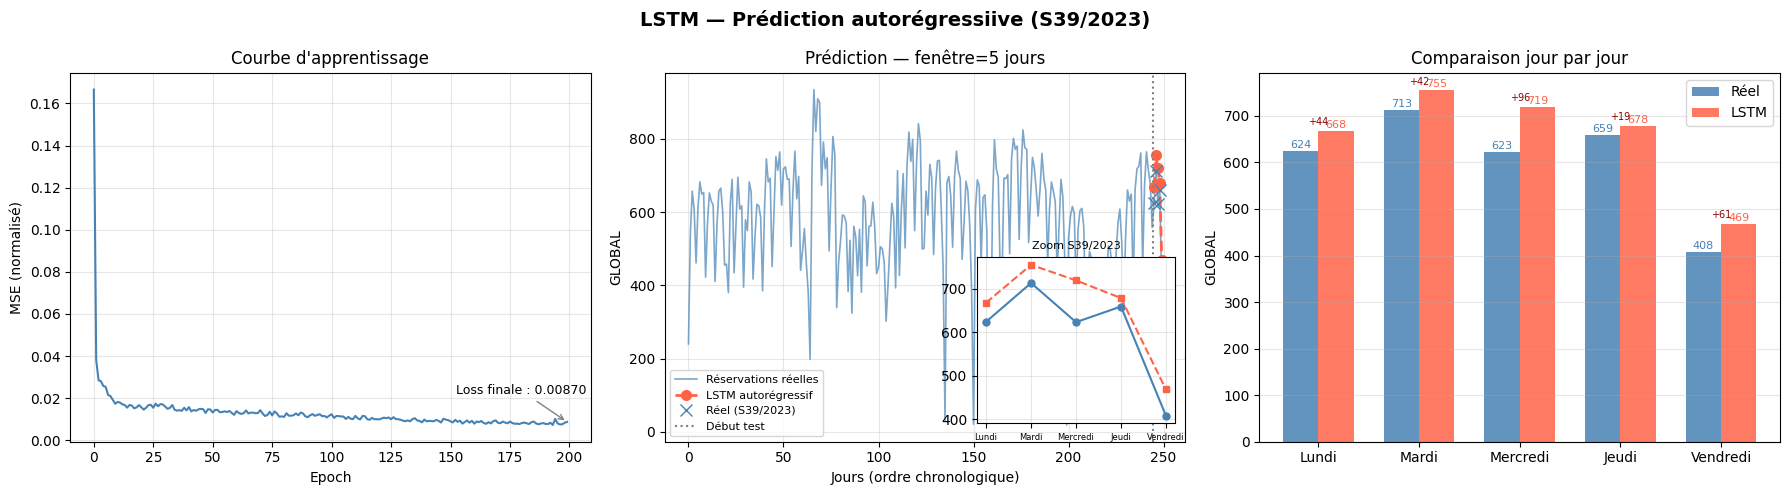

Figure sauvegardée → ../img/lstm_results.png


In [9]:
all_real     = df[TARGET_COL].values
test_indices = list(range(len(all_real) - N_TEST, len(all_real)))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle(f'{MODEL_NAME} — Prédiction autorégressiive ({TEST_LABEL})',
             fontsize=14, fontweight='bold')

# ── 1 : Courbe d'apprentissage ────────────────────────────────────────────
ax = axes[0]
ax.plot(loss_history, color='steelblue', lw=1.5)
ax.set_xlabel('Epoch')
ax.set_ylabel('MSE (normalisé)')
ax.set_title('Courbe d\'apprentissage')
ax.grid(alpha=0.3)
ax.annotate(f'Loss finale : {loss_history[-1]:.5f}',
            xy=(len(loss_history) - 1, loss_history[-1]),
            xytext=(-80, 20), textcoords='offset points',
            arrowprops=dict(arrowstyle='->', color='gray'), fontsize=9)

# ── 2 : Série complète + prédiction ─────────────────────────────────────
ax = axes[1]
ax.plot(range(len(all_real)), all_real,
        label='Réservations réelles', color='steelblue', alpha=0.7, lw=1.2)
ax.plot(test_indices, preds_real,
        label=f'{MODEL_NAME} autorégressif', color='tomato',
        ls='--', marker='o', ms=7, lw=2)
ax.plot(test_indices, real_real,
        color='steelblue', marker='x', ms=9, ls='None', label=f'Réel ({TEST_LABEL})')
ax.axvline(x=test_indices[0] - 0.5, color='gray', ls=':', lw=1.5, label='Début test')
ax.set_xlabel('Jours (ordre chronologique)')
ax.set_ylabel(TARGET_COL)
ax.set_title(f'Prédiction — fenêtre={WINDOW} jours')
ax.legend(fontsize=8)
ax.grid(alpha=0.3)

# Zoom inset
axins = ax.inset_axes([0.60, 0.05, 0.38, 0.45])
axins.plot(DAY_LABELS, real_real, 'o-', color='steelblue', ms=5)
axins.plot(DAY_LABELS, preds_real, 's--', color='tomato', ms=5)
axins.set_title(f'Zoom {TEST_LABEL}', fontsize=8)
axins.tick_params(axis='x', labelsize=6)
axins.grid(alpha=0.3)

# ── 3 : Barres côte à côte ───────────────────────────────────────────────
ax    = axes[2]
x     = np.arange(N_TEST)
width = 0.35
b_r   = ax.bar(x - width/2, real_real,  width, label='Réel',          color='steelblue', alpha=0.85)
b_p   = ax.bar(x + width/2, preds_real, width, label=MODEL_NAME,      color='tomato',    alpha=0.85)
for bar, val in zip(b_r, real_real):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
            f'{val:.0f}', ha='center', va='bottom', fontsize=8, color='steelblue')
for bar, val in zip(b_p, preds_real):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
            f'{val:.0f}', ha='center', va='bottom', fontsize=8, color='tomato')
ax.set_xticks(x)
ax.set_xticklabels(DAY_LABELS)
ax.set_ylabel(TARGET_COL)
ax.set_title('Comparaison jour par jour')
ax.legend()
ax.grid(axis='y', alpha=0.3)
# Annoter les erreurs
for i in range(N_TEST):
    err = preds_real[i] - real_real[i]
    ax.text(i, max(real_real[i], preds_real[i]) + 12,
            f'{err:+.0f}', ha='center', fontsize=7, color='darkred')

plt.tight_layout()
plt.savefig(IMG_PATH, dpi=150, bbox_inches='tight')
plt.show()
print(f'Figure sauvegardée → {IMG_PATH}')

## 10 — Trace de la fenêtre glissante

Récapitulatif des prédictions injectées à chaque étape.

In [10]:
print(f'=== Trace de la fenêtre glissante — {MODEL_NAME} ===')
print(f"{'Étape':<7} {'Jour':<12} {'Réel':>6} {'Prédit':>7} {'Err abs':>8} {'Err %':>7}   Rôle")
print('-' * 75)
for i, d in enumerate(DAY_LABELS):
    err_abs = abs(preds_real[i] - real_real[i])
    err_pct = 100 * err_abs / real_real[i]
    role = '← injecté dans la fenêtre suivante' if i < N_TEST - 1 else '← prédiction finale'
    print(f'  {i}      {d:<12} {real_real[i]:>6.0f} {preds_real[i]:>7.0f} {err_abs:>8.1f} {err_pct:>6.1f}%   {role}')

print(f'\nRésumé : MAE={mae:.1f} | MAPE={mape:.2f}% | RMSE={rmse:.1f} | R²={r2:.4f}')

=== Trace de la fenêtre glissante — LSTM ===
Étape   Jour           Réel  Prédit  Err abs   Err %   Rôle
---------------------------------------------------------------------------
  0      Lundi           624     668     43.7    7.0%   ← injecté dans la fenêtre suivante
  1      Mardi           713     755     41.8    5.9%   ← injecté dans la fenêtre suivante
  2      Mercredi        623     719     96.0   15.4%   ← injecté dans la fenêtre suivante
  3      Jeudi           659     678     19.4    2.9%   ← injecté dans la fenêtre suivante
  4      Vendredi        408     469     60.5   14.8%   ← prédiction finale

Résumé : MAE=52.3 | MAPE=9.21% | RMSE=58.1 | R²=0.6874
